# Biomedical Imaging and Analytics
## Seminar 5. ML/Image2Image and Cardiac Imaging. Part 1.

Here we would like to present some code from our article *Optical Mapping-Validated Machine Learning Improves Atrial Fibrillation Driver Detection by Multi-Electrode Mapping*, published in Circulation EP, 2020

**Outline**
- Creation and preprocessing of electrograms spectrum 
- Spectrum's feature generation 
- Classification 

The core idea is to define the sources (or drivers) of Atrial Fibrillation based on spectral features of **Multi-electrode mapping (MEM)** recordings. The main strenght of the study is that Ground Truth labels for supervised learning was known from other modality, **Near-Infrared Optical mapping (NIOM)**, which can record subsurface electrical activity with high resolution. As dataset we used explanted human hearts from Cardiac Imaging lab, The Ohio State university.  


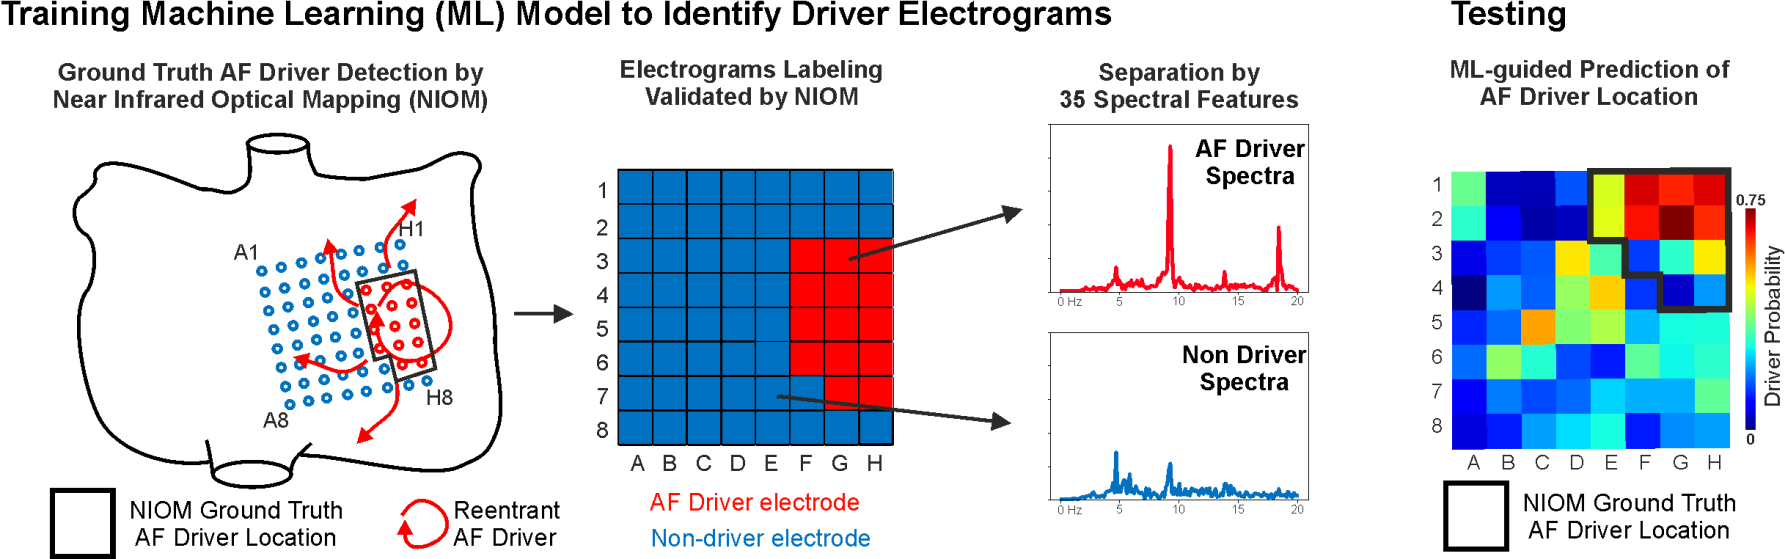

In [8]:
display.Image("./pipeline.png", width=900)

In [3]:
#all required imports
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob

from scipy.signal import find_peaks,lfilter, butter, welch
from tqdm import tqdm

from IPython import display
import IPython

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score,classification_report,cohen_kappa_score
from sklearn.metrics import roc_curve,auc,precision_score,recall_score

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

from print_metrics import results_full_test

import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Please make sure that *electrograms.csv* file are downloaded to the *\data* folder 

In [4]:
#load data
electrograms = pd.read_csv('.\data\electrograms.csv')

# Part 1

Due to sensitivity of medical data we will generate spectrums and its features only on couple raw electrograms. 

### Visualization of the data

Before shift into Fourier space let us look at the raw electrogram data. You may notice that despite MEM and NIOM data is obtained from the same atria, their nature are different.

In [5]:
def plot_raw_data(signal_type, part):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13,5))

    fig.suptitle(signal_type + ' electrograms', fontsize = 20,  y=1.05)

    ax[0].plot(electrograms[signal_type + ' driver'][:part])
    ax[0].set_title('AFib driver', fontsize=15)
    ax[1].plot(electrograms[signal_type+' no driver'][:part])
    ax[1].set_title('No driver', fontsize=15)
    fig.tight_layout()
    plt.show()

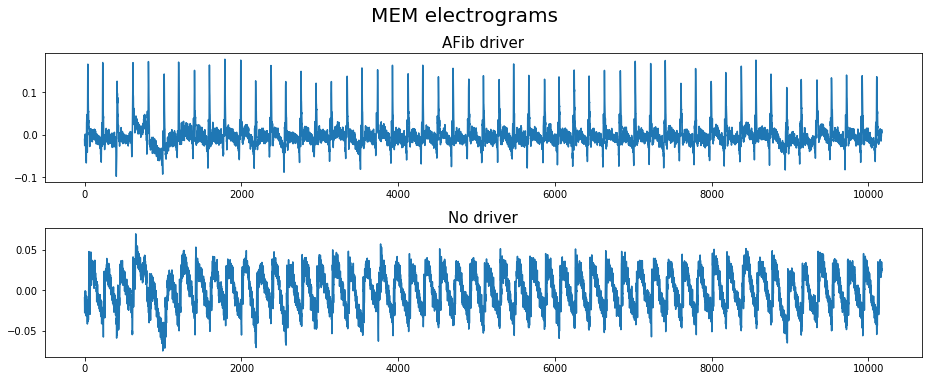

In [6]:
plot_raw_data('MEM', -1)

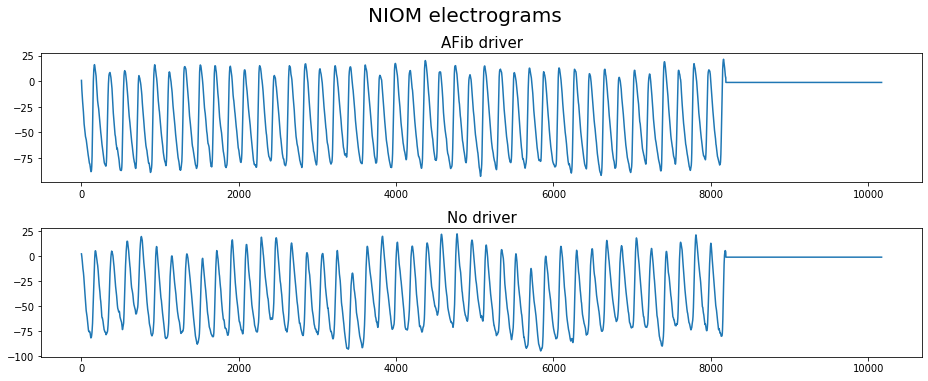

In [7]:
plot_raw_data('NIOM', -1)

Let's look closer and plot 1 sec of signals from both modalities

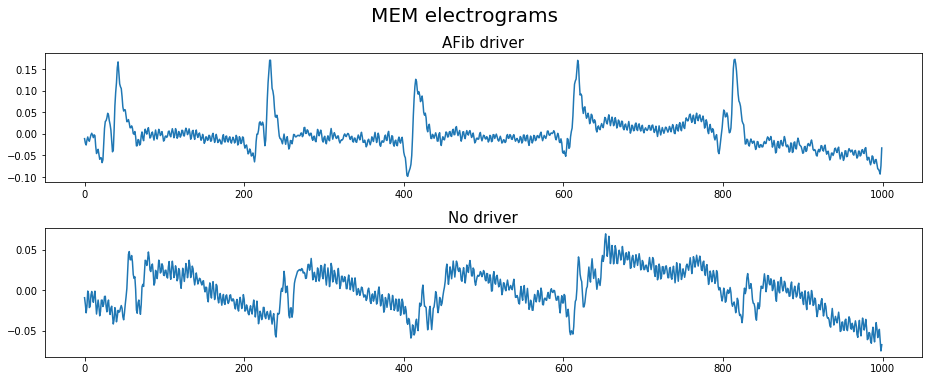

In [8]:
plot_raw_data('MEM', 1000)

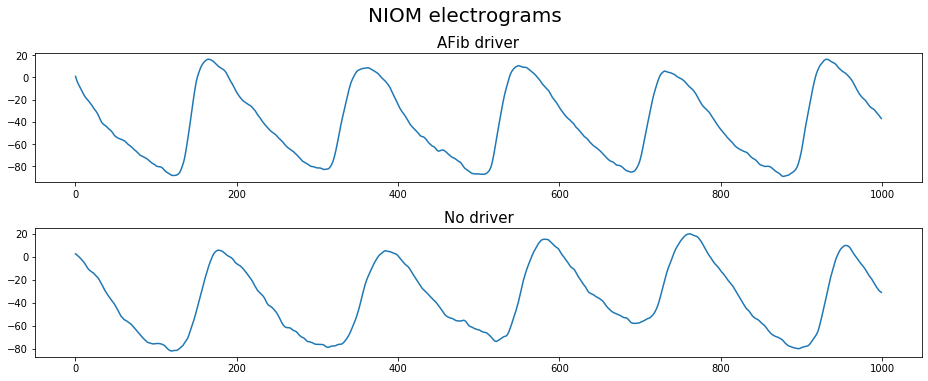

In [9]:
plot_raw_data('NIOM', 1000)

### Spectrum generation by Fourier transform

In [10]:
fs_mem = 1017.25 # sampling rate of MEM electrograms
fs_niom = 1000.0  # sampling rate of NIOM electrograms

lowcut = 2
highcut = 20

def cut_off(fft_yf, fft_xf, lowcut=0, highcut=20):
    fft_index = np.argwhere((fft_xf<=highcut) & (fft_xf>=lowcut))        
    fft_yf = fft_yf[fft_index] #cutting on 20Hz
    fft_xf = fft_xf[fft_index] #cutting on 20Hz 
    return fft_yf, fft_xf

def butter_bandpass(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    
    high = highcut / nyq
    low = lowcut / nyq
    
    b, a = butter(order, [low, high], btype='bandpass', analog=False)
    filtered_signal = lfilter(b, a, data)
    
    return filtered_signal

def spectrum_generation(df, type_of_signal, fs, i=0, cut=False, bpfilter=False, plot=True, return_df=False):
    preprocessed_electrograms = {}
    for j, col in enumerate(df.loc[:, df.columns.str.startswith(type_of_signal)]):
        signal = df[col]
        N = len(signal)
        
        if bpfilter:
            signal = butter_bandpass(signal, lowcut, highcut, fs, order=2)
            
        fft_yf = np.fft.fft(signal) #spectrum
        fft_xf = np.fft.fftfreq(N, 1/fs) #frequencies
        
        if cut:
            fft_yf, fft_xf = cut_off(fft_yf, fft_xf)
        if plot:
            ax[i, j].plot(fft_xf, np.abs(fft_yf), label=col)
            ax[i, j].set_title("Spectrum of " + col)
            
        preprocessed_electrograms[col] = np.abs(fft_yf).ravel()

        df_out = pd.DataFrame.from_dict(preprocessed_electrograms)
    if return_df:
        return df_out

               
spectrum_demo = pd.concat([spectrum_generation(electrograms, 'MEM', fs_mem, cut=True, bpfilter=True, plot=False, return_df=True), 
                           spectrum_generation(electrograms, 'NIOM', fs_niom,  cut=True, bpfilter=True, plot=False, return_df=True)], axis=1)

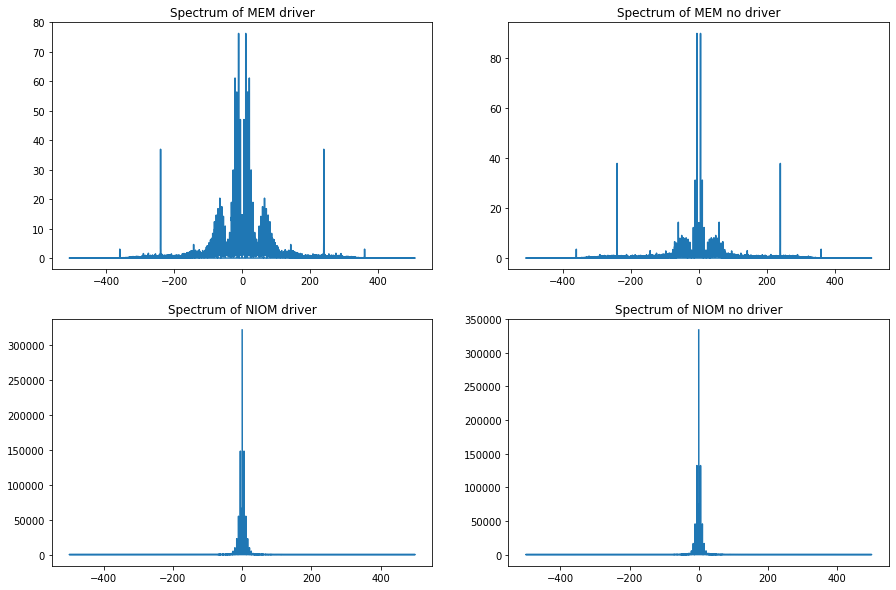

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

spectrum_generation(electrograms, "MEM", fs_mem, i=0)
spectrum_generation(electrograms, "NIOM", fs_niom, i=1)

From the physiological point of view, human atria are beating in range of \[0, 20\]Hz. So all other frequencies are represent some noise or experiment atrifacts and we can remove them.


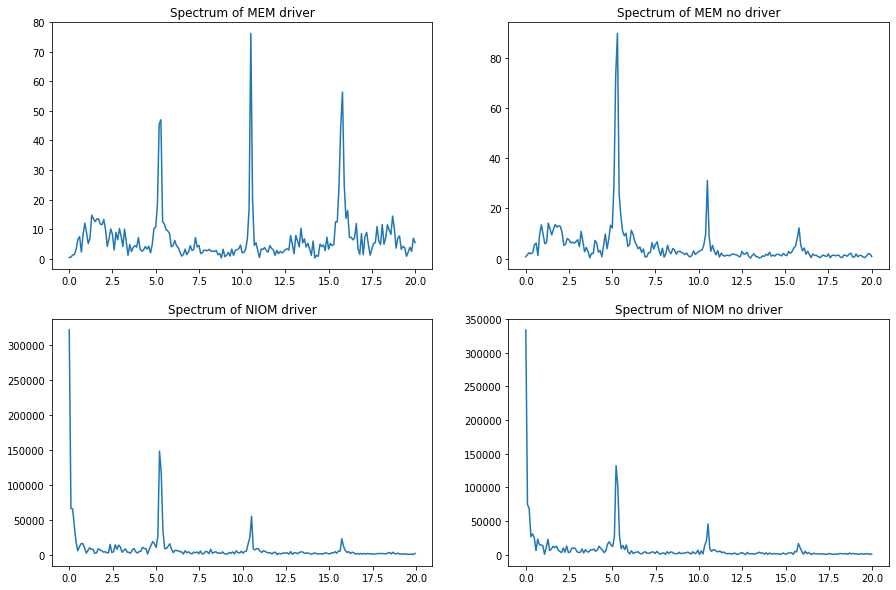

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10)) 

spectrum_generation(electrograms, "MEM", fs_mem, i=0, cut=True)
spectrum_generation(electrograms, "NIOM", fs_niom, i=1, cut=True)

### Preprocessing

Now we will apply bandpass filter that will remove low-frequency noise

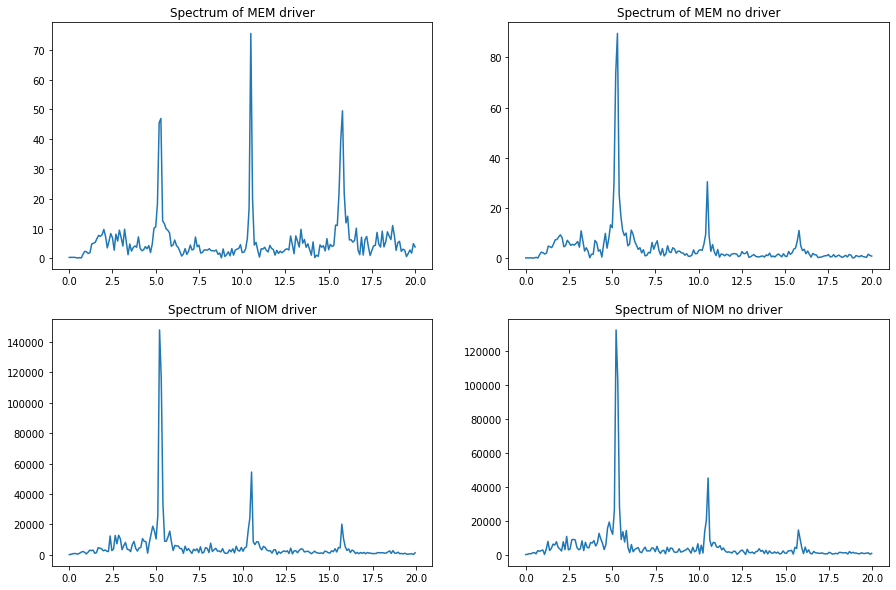

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

spectrum_generation(electrograms, "MEM", fs_mem, i=0, cut=True, bpfilter=True)
spectrum_generation(electrograms, "NIOM", fs_niom, i=1, cut=True, bpfilter=True) 

## Feature generation

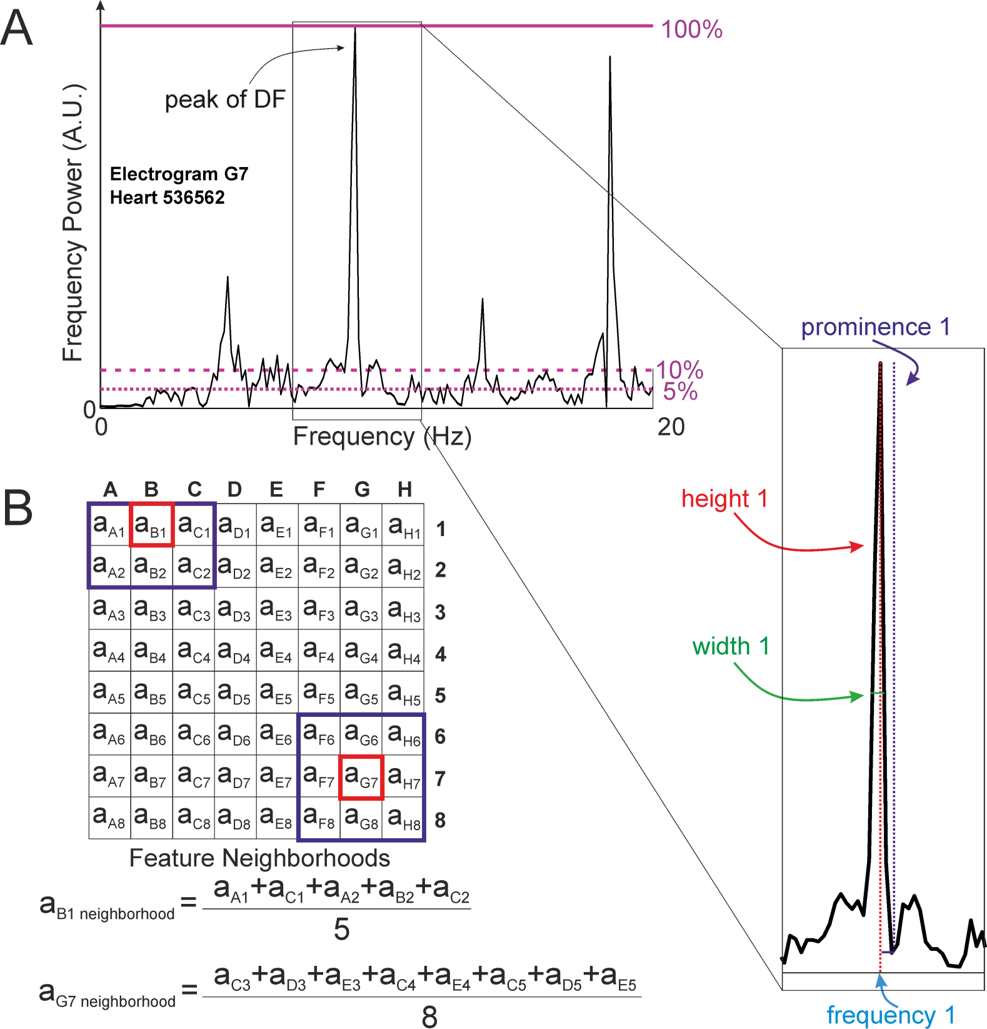

In [15]:
IPython.display.Image("./features.png", width=700)

In [16]:
def number_of_peaks(df, th):
    num_of_peaks = []
    all_props = []
        
    for col in df:
        _, properties = find_peaks(df[col], height=0)
        all_props.append(properties)

    for i in range(len(all_props)):
        if len(all_props[i]['peak_heights']) < 5:
            num = 0
        else:
            max_height = np.max(all_props[i]['peak_heights'])
            peaks, _ = find_peaks(df.iloc[:,i], threshold=th*max_height)
            num = peaks.shape[0]
        num_of_peaks.append(num)
    num_of_peaks = pd.DataFrame(num_of_peaks, columns=['#peaks_' + str(th)], index=df.columns)
    return(num_of_peaks)

In [17]:
#threshhold = 5%
number_of_peaks(spectrum_demo, 0.05)

,#peaks_0.05
MEM driver,9
MEM no driver,2
NIOM driver,4
NIOM no driver,4


In [18]:
def properties_of_peaks(spectrum, n): 
    
    index = []
    freq = []
    height = []
    width = []
    prominence = []
    
    spectrum_lengh, number_sample = spectrum.shape
    df = spectrum
    xf = np.tile(np.linspace(0,20, num = spectrum_lengh), (number_sample,1)).reshape(-1, number_sample)
    all_peaks = []
    all_props = []
    
    #find all peaks in the Fourier spectra 
    for col in df:
        peaks, properties = find_peaks(df[col], height=0, width=0, prominence=0, rel_height=0.5)
        properties['peak_index'] = peaks
        all_props.append(properties)
        all_peaks.append(peaks)
   
    #calculate features for 5 biggest peaks
    for i in range(len(all_props)):
        z = np.argsort(all_props[i]['peak_heights'])
        z = z[:-(n+1):-1]
        if len(z) < 5:
            zeros_raw_n=np.zeros(n)
            height.append(zeros_raw_n)
            width.append(zeros_raw_n)
            prominence.append(zeros_raw_n)
            for j in range(n):
                fr = np.zeros(1)
                freq.append(fr)                
        else:       
            idx = all_props[i]['peak_index'][z] #index of max peaks
            for j in range(n):
                fr = xf[:,i][all_peaks[i][z][j]] #freqs of max peaks
                freq.append(fr)

            h = all_props[i]['peak_heights'][z] #heights of max peaks
            height.append(h)
            
            w = all_props[i]['widths'][z] #width of max peaks
            width.append(w)
            p = all_props[i]['prominences'][z]
            prominence.append(p)
            

    freq = np.reshape(freq, (number_sample, n)) 
    freq = pd.DataFrame(freq, columns=['freq ' + str(i) for i in range(n)])
    height = pd.DataFrame(height, columns=['height ' + str(i) for i in range(n)])
    width = pd.DataFrame(width, columns=['width ' + str(i) for i in range(n)])
    prominence = pd.DataFrame(prominence, columns=['prominence ' + str(i) for i in range(n)])
    peaks_10 = number_of_peaks(df, 0.1).reset_index(drop=True)
    peaks_5 = number_of_peaks(df, 0.05).reset_index(drop=True)

    features = pd.concat([freq, height, width, height, prominence, peaks_10, peaks_5], axis=1)
    features.index = df.columns
    return(features)

In [19]:
properties_of_peaks(spectrum_demo, n=5)

,freq 0,freq 1,freq 2,freq 3,freq 4,height 0,height 1,height 2,height 3,height 4,...,height 2,height 3,height 4,prominence 0,prominence 1,prominence 2,prominence 3,prominence 4,#peaks_0.1,#peaks_0.05
MEM driver,1.182266,1.970443,0.788177,3.152709,0.394089,75.522465,49.547694,46.948675,14.128948,11.135108,...,46.948675,14.128948,11.135108,75.270024,48.966420,46.800098,2.243501,0.091686,2,9
MEM no driver,0.886700,1.280788,19.408867,4.039409,2.068966,89.481463,30.466913,13.286729,11.214889,11.063155,...,13.286729,11.214889,11.063155,89.332453,29.656660,1.106403,6.265525,10.680212,2,2
NIOM driver,0.985222,2.167488,2.955665,19.507389,3.349754,148033.892234,54364.068149,20046.688896,18686.622771,15420.287460,...,20046.688896,18686.622771,15420.287460,147964.844478,53619.239400,19950.374608,8385.158277,6631.879341,2,4
NIOM no driver,1.083744,2.266010,19.605911,3.054187,3.448276,132152.748381,45045.330972,19128.973396,14467.142279,14175.064032,...,19128.973396,14467.142279,14175.064032,132104.068478,44686.894088,7210.256902,14253.692265,6805.041580,2,4


It was a demonstration of how to obtain features from the raw electrogram data and its  spectrum. Now we will switch to another dataframe that contains already calculated and preprocessed MEM spectrums. Here are provided 1000 randomly sampled spectrums in order to speed up all calculations.

In [31]:
spectra = pd.read_csv('./data/MEM spectrum.csv', index_col=0)
spectra.reset_index(inplace=True, drop=True)
print(spectra.shape)
target = spectra.target
df = spectra.iloc[:,:-2]
df = df.transpose()

(1000, 100)


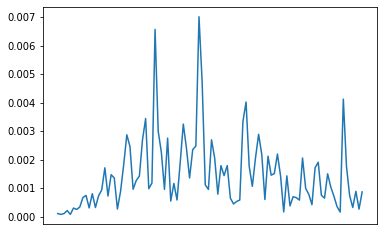

In [32]:
plt.plot(df.iloc[:, 0])
plt.xticks([])
plt.show()

In [22]:
target.value_counts()

 0.0    726
 0.5    116
 1.0    106
-1.0     52
Name: target, dtype: int64

The target values in this study is means following: \
0 : No driver \
0.5 : Periphery AFib driver electrode \
1 : AFib driver \
-1 : Noise 

In [23]:
features = properties_of_peaks(df, n=5)
features['target'] = target

In [24]:
features.head()

,freq 0,freq 1,freq 2,freq 3,freq 4,height 0,height 1,height 2,height 3,height 4,...,height 3,height 4,prominence 0,prominence 1,prominence 2,prominence 3,prominence 4,#peaks_0.1,#peaks_0.05,target
0,3.71134,6.59794,11.5464,4.94845,14.433,0.007014,0.006569,0.004123,0.004022,0.003440,...,0.004022,0.003440,0.006856,0.006025,0.003861,0.003579,0.002461,9,19,0.0
1,8.86598,7.62887,5.15464,12.5773,13.4021,0.057843,0.006902,0.006745,0.005206,0.004250,...,0.005206,0.004250,0.057642,0.006248,0.002231,0.001916,0.001609,1,2,1.0
2,0.412371,1.23711,9.48454,9.07216,5.7732,0.005462,0.002388,0.002111,0.002058,0.002010,...,0.002058,0.002010,0.005365,0.002273,0.000298,0.000999,0.000432,3,12,0.0
3,6.39175,4.74227,15.0515,3.91753,18.7629,0.006037,0.003158,0.002456,0.002309,0.002286,...,0.002309,0.002286,0.005996,0.002836,0.002112,0.001861,0.000981,9,15,0.0
4,9.48454,3.29897,15.2577,2.8866,4.12371,0.045617,0.014779,0.011410,0.009097,0.008926,...,0.009097,0.008926,0.045072,0.014114,0.005004,0.003993,0.007833,1,6,0.0


Calculation of **neighbor features** we will omit in this study, since we work randomly sampled spectrum, not with a full grid.

## Now let's proceed to the classification

First of all we will remap target labels in order to reduce the task to binary classification. Then normalize the features, this may benefit for non-tree based methods. 

In [25]:
data = features.loc[~features['target'].isin([-1])] #drop noise 
data['target'] = data['target'].map({1: 1, 0: 0,0.5:0})

X = data.drop('target', axis=1)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

encoder = StandardScaler()
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

Now let's train and visualise results

In [26]:
def train(model, param_grid, cv, X_train, y_train, X_test, y_test):
    optimizer = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1,scoring='f1')
    optimizer.fit(X_train, y_train)
    y_proba = optimizer.best_estimator_.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1])
    roc_auc = auc(fpr, tpr)
    return y_proba, fpr, tpr, threshold , roc_auc, optimizer

def results(model, param_grid, cv, X_train,y_train, X_test, y_test):
    
    y_proba_train, fpr_train, tpr_train, _, roc_auc1_train, _ = train(model, param_grid, cv, X_train, y_train, X_train, y_train)
    y_proba_test, fpr_test, tpr_test, threshold_test, roc_auc1_test, optimizer = train(model, param_grid, cv, X_train, y_train, X_test, y_test)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].set_title('Receiver Operating Characteristic for train')
    ax[0].plot(fpr_train, tpr_train, 'b', label = 'AUC1 = %0.2f' % roc_auc1_train)
    ax[0].legend(loc = 'lower right')
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    
    ax[1].set_title('Receiver Operating Characteristic for test')
    ax[1].plot(fpr_test, tpr_test, 'b', label = 'AUC1 = %0.2f' % roc_auc1_test)
    ax[1].legend(loc = 'lower right')
    ax[1].plot([0, 1], [0, 1],'r--')
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    
    plt.show()
        
    print("Model characteristics - ",optimizer.best_estimator_) 
    return optimizer,fpr_test,tpr_test,threshold_test

### kNN

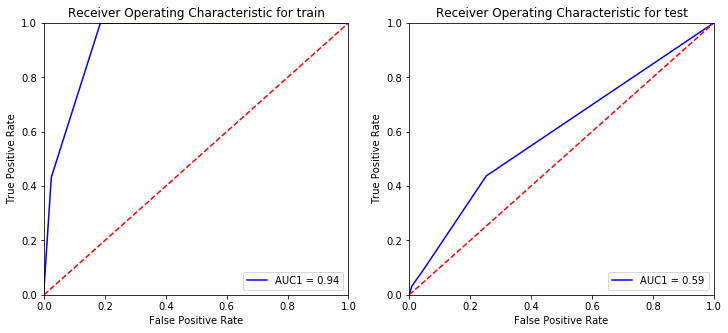

Model characteristics -  KNeighborsClassifier(n_neighbors=3)


In [27]:
model = KNeighborsClassifier()
cv=5
param_grid = {'n_neighbors': [3,4,5,6,7]}
optimizer,fpr,tpr,threshold = results(model, param_grid, cv, X_train, y_train, X_test, y_test)  

As you may notice, the data we work with is highly imbalanced. The accuracy metric is not representative in this case, so we will look at F1-score, recall and presicion as well. Confidence intervals are calculated as well. 

In [28]:
results_full_test(optimizer, 0.5, X_test , y_test)

Model accuracy: mean 0.856, std 0.037
Model accuracy 95%% confidence interval: [0.825 0.888]
Model precision: mean 0.146, std 0.226
Model precision 95%% confidence interval: [-0.043  0.335]
Model recall: mean 0.094, std 0.129
Model recall 95%% confidence interval: [-0.014  0.202]
Model f1-score: mean 0.108, std 0.155
Model f1-score 95%% confidence interval: [-0.021  0.238]
